In [193]:
import sys
python = sys.executable # get python executable path
print(python)

for i in ["numpy",  "scipy", "matplotlib", "pandas", "opencv-python", "opencv-contrib-python"]: # declare what packages we need
  print(f"Installing: {i}")
  ! $python -m pip install $i # install packages calling bash command from the notebook, e.g. "/usr/bin/python -m pip install numpy"

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import urllib.request
import cv2

/usr/bin/python3
Installing: numpy
Installing: scipy
Installing: matplotlib
Installing: pandas
Installing: opencv-python
Installing: opencv-contrib-python


# Подготовка данных

## Загрузка изображений

### Для склейки панорамы

In [194]:
url = "https://files.vgtimes.ru/posts/2023-04/1682692370_6.jpg"
urllib.request.urlretrieve(url, "image.jpg")

('image.jpg', <http.client.HTTPMessage at 0x7a34a1aab010>)

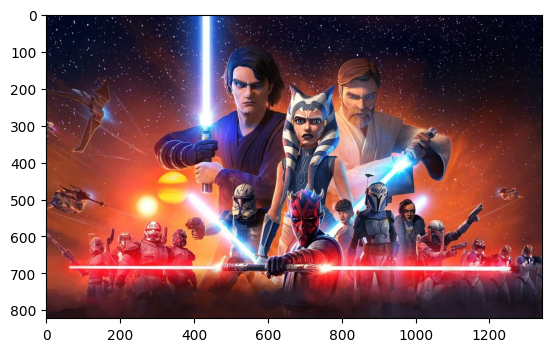

In [195]:
img = cv2.imread("image.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img);

In [196]:
img.shape

(822, 1343, 3)

### Для оптического потока

In [296]:
flow1 = cv2.cvtColor(cv2.imread("test1.jpg"), cv2.COLOR_BGR2RGB)
flow2 = cv2.cvtColor(cv2.imread("test2.jpg"), cv2.COLOR_BGR2RGB)

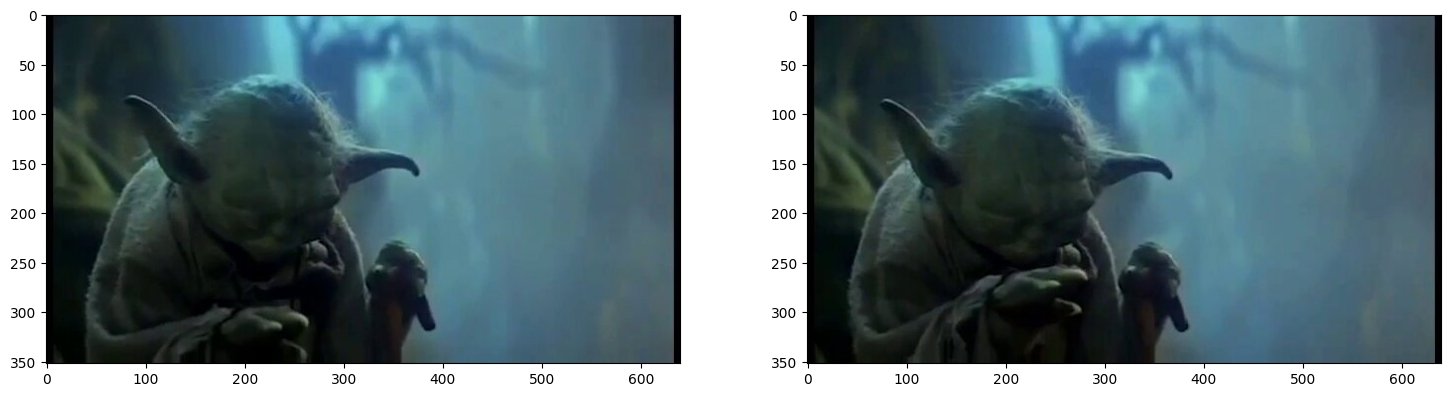

In [297]:
fig, ax = plt.subplots(1, 2, figsize=(18, 9))

ax[0].imshow(flow1);
ax[1].imshow(flow2);

## Изменение размера изображения

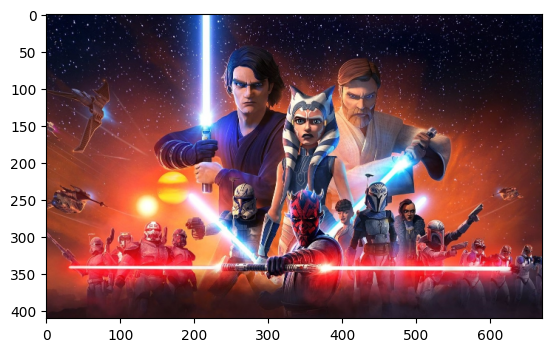

In [197]:
scale_percent = 50
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dsize = (width, height)
img = cv2.resize(img, dsize)
plt.imshow(img);

In [198]:
img.shape

(411, 671, 3)

# Задание 1 Склейка панорамы


* Создать две или более фото с частичным перекрытием
* Имплементировать алгоритм склейки панорамы
stitch_images(images, *args, **kwargs) Который принимает на входе
массив изображений, выдает склейку, или None, если пересечения
недостаточно.
* Отобразить входные изображения и алгоритм склейки
 + отобразить ключевые точки на каждом изображении
 + отобразить сопоставления между изображениями

Важно! Можно ограничиться только горизонтальной склейкой.



## 1.1 Создание фото с частичным перекрытием

In [199]:
overlap_percent = 30
left_image_width_percent = 60

left_width = int(img.shape[1] * left_image_width_percent / 100)
right_width = int((img.shape[1] - left_width) * (1 + overlap_percent / 100))

img1, img2 = img[:, :left_width, :], img[:, -right_width:, :]

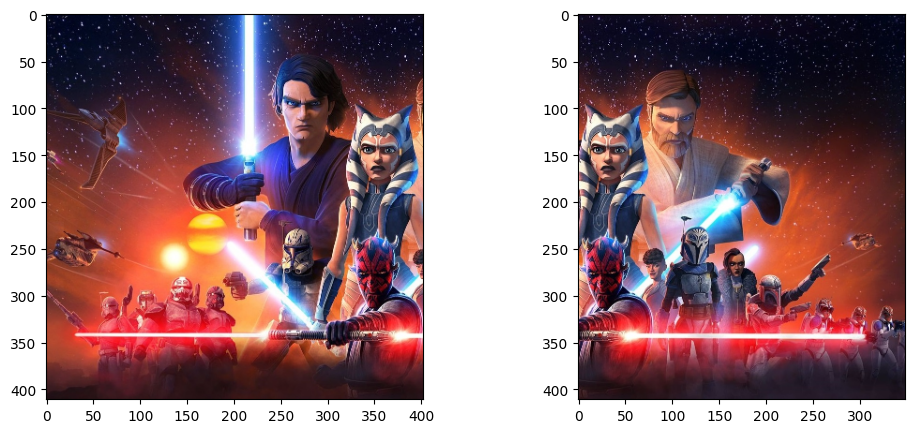

In [200]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].imshow(img1);
ax[1].imshow(img2);

## 1.2 Имплементация алгоритма склейки

In [201]:
def stitch_images(image1: np.ndarray, image2: np.ndarray, k_best_matches: int = 100, best_matches_threshold : int = 20) -> tuple[np.ndarray] | None:
    gray_image1 = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
    gray_image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(gray_image1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(gray_image2, None)

    bf_matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    best_matches = sorted(
        bf_matcher.match(descriptors2, descriptors1),
        key=lambda x: x.distance
    )[:k_best_matches]

    if len(best_matches) < best_matches_threshold:
        return None

    src_points = np.array([keypoints2[m.queryIdx].pt for m in best_matches], dtype=np.float32).reshape(-1, 1, 2)
    dst_points = np.array([keypoints1[m.trainIdx].pt for m in best_matches], dtype=np.float32).reshape(-1, 1, 2)

    homography, _ = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 5.0)

    width = image1.shape[1] + image2.shape[1]
    height = image1.shape[0]

    result = cv2.warpPerspective(image2, homography, (width, height))
    result[:image1.shape[0], :image1.shape[1]] = image1

    image1_keypoints = cv2.drawKeypoints(image1, keypoints1, None)
    image2_keypoints = cv2.drawKeypoints(image2, keypoints2, None)
    image_best_matches = cv2.drawMatches(image1_keypoints, keypoints1, image2_keypoints, keypoints2, sorted(
        bf_matcher.match(descriptors1, descriptors2),
        key=lambda x: x.distance
    )[:k_best_matches], None)

    return image1_keypoints, image2_keypoints, image_best_matches, result

## 1.3 Демонстрация работы алгоритма

In [202]:
image1_keypoints, image2_keypoints, image_best_matches, result = stitch_images(img1, img2)

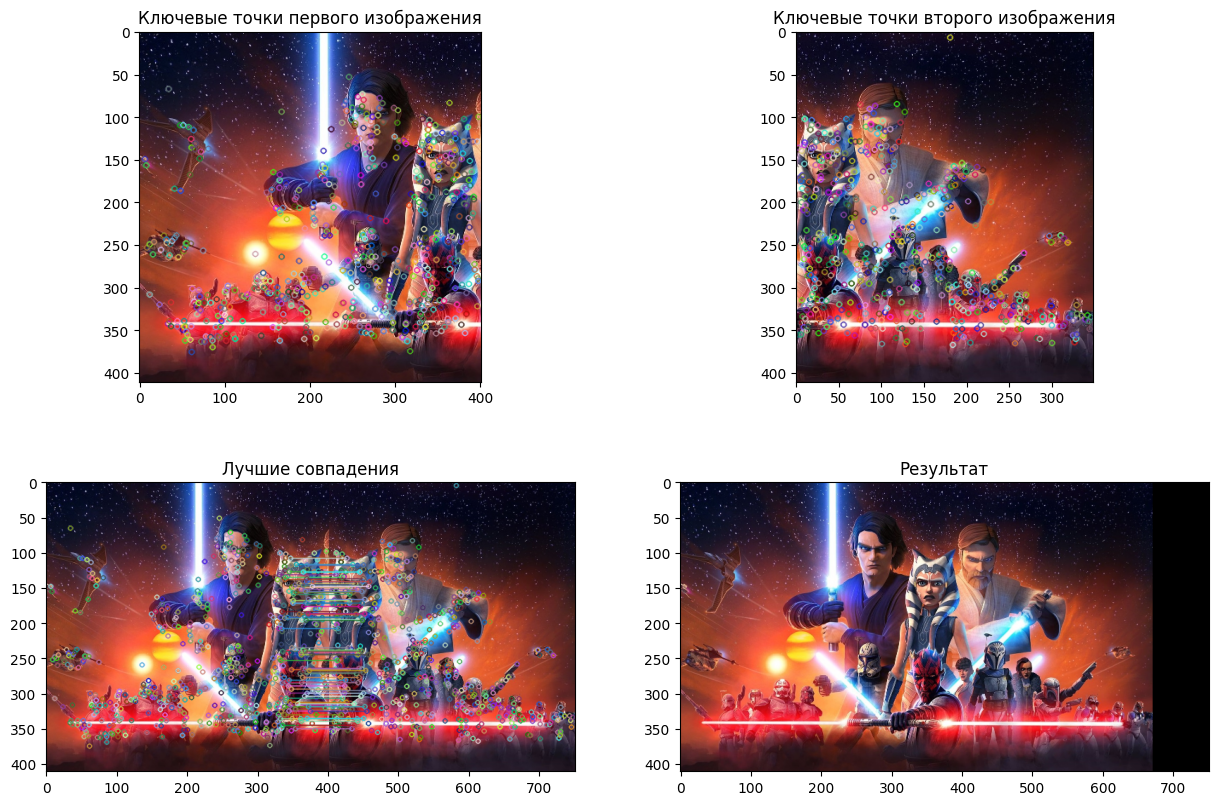

In [203]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

ax[0, 0].set_title('Ключевые точки первого изображения')
ax[0, 0].imshow(image1_keypoints)

ax[0, 1].set_title('Ключевые точки второго изображения')
ax[0, 1].imshow(image2_keypoints)

ax[1, 0].set_title('Лучшие совпадения')
ax[1, 0].imshow(image_best_matches)

ax[1, 1].set_title('Результат')
ax[1, 1].imshow(result)

# Задание 2 Оптический поток Лукаса — Канаде


1. Загрузить видео или набор изображений с изменением сцены и
перевести в grayscale

2. Имплементировать алгоритм оптического потока Лукаса —
Канаде.

3. Отобразить результат применения алгоритма по кадрам

Базовая функция optic_flow(img1,img2,window_size)

На выходе должна быть карта смещений блоков пикселей

## 2.1 Имплементация оптического потока

In [322]:
def optical_flow(
        image1: np.ndarray,
        image2: np.ndarray,
        window_size: int,
        max_corners: int = 10000,
        min_distance: float = 0.1,
        min_quality: float = 0.05
    ) -> tuple[np.ndarray, np.ndarray]:

    gray_image1 = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
    gray_image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

    # углы
    corners = cv2.goodFeaturesToTrack(
        gray_image1, max_corners, min_quality, min_distance
    )

    dx = cv2.Sobel(gray_image1, ddepth=-1, dx=1, dy=0, ksize=3)
    dy = cv2.Sobel(gray_image1, ddepth=-1, dx=0, dy=1, ksize=3)

    dt = gray_image2 - gray_image1

    u = np.zeros(gray_image1.shape)
    v = np.zeros(gray_image1.shape)

    for corner in corners:
        j, i = corner.ravel()
        i, j = int(i), int(j)

        left_first = i - window_size
        right_first = i + window_size + 1

        left_second = j - window_size
        right_second = j + window_size + 1

        I_x = dx[
            left_first : right_first,
            left_second : right_second
        ].flatten()

        I_y = dy[
            left_first : right_first,
            left_second : right_second
        ].flatten()

        I_t = dt[
            left_first : right_first,
            left_second : right_second
        ].flatten()

        b = np.reshape(I_t, (I_t.shape[0], 1))
        A = np.vstack((I_x, I_y)).T

        res = np.linalg.lstsq(A, b, rcond=None)[0]

        u[i, j] = res[0]
        v[i, j] = res[1]

    return u, v

Вспомогательная функция по отрисовке стрелок оптического потока

In [334]:
def arrow_image(image: np.ndarray, u: np.ndarray, v: np.ndarray, line_color: tuple[int, int, int] = (0, 255, 0)) -> np.ndarray:
    frame = image.copy()

    for i in range(frame.shape[0]):
        for j in range(frame.shape[1]):
            U, V = u[i][j], v[i][j]

            if U and V:
                frame = cv2.arrowedLine(
                    frame,
                    (i, j),
                    (int(round(i + U)), int(round(j + V))),
                    line_color,
                    thickness=1
                )

    return frame

## Демонстрация работы алгоритма

In [335]:
u, v = optical_flow(flow1, flow2, 3)

<ipython-input-322-09d52cee9c07>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[i, j] = res[0]
<ipython-input-322-09d52cee9c07>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v[i, j] = res[1]


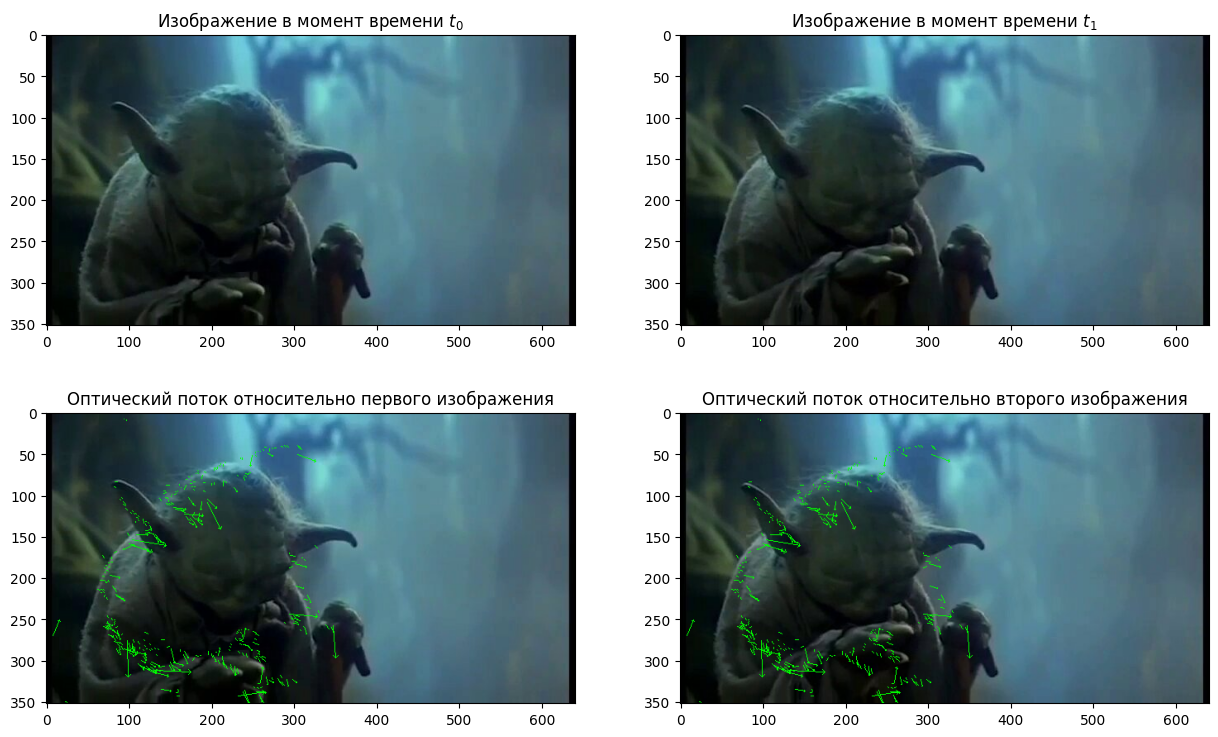

In [336]:
fig, ax = plt.subplots(2, 2, figsize=(15, 9));

ax[0, 0].set_title('Изображение в момент времени $t_0$');
ax[0, 0].imshow(flow1);

ax[0, 1].set_title('Изображение в момент времени $t_1$');
ax[0, 1].imshow(flow2);

ax[1, 0].set_title('Оптический поток относительно первого изображения');
ax[1, 0].imshow(arrow_image(flow1, u, v));

ax[1, 1].set_title('Оптический поток относительно второго изображения');
ax[1, 1].imshow(arrow_image(flow2, u, v));